<a href="https://colab.research.google.com/github/MUbarak123-56/cnn-vs-vit/blob/master/ViT_food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViT Model Training on Food Data

### Package Installation

In [1]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Loading the data

In [2]:
from datasets import load_dataset
food = load_dataset("food101", split="train[:5000]")

In [3]:
food = food.train_test_split(test_size=0.2)
food_use = food.copy()
food["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384 at 0x7F9E668A3310>,
 'label': 79}

In [4]:
food["test"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7F9D8142EF90>,
 'label': 77}

In [5]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [6]:
labels

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

### Visualizing the data

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import numpy as np

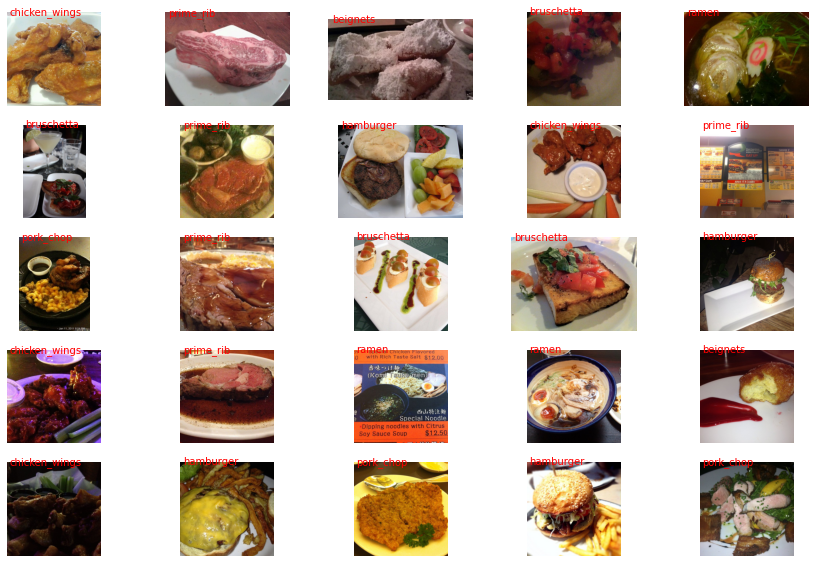

In [9]:
fig, axArr = plt.subplots(5,5,figsize=(15,10));
# loop through all rows
for currRow in range(5):
 # loop through all columns
 for currCol in range(5):
 # select the random digi
  n = np.random.randint(0,len(food["train"]))
  randomDigitImage = food["train"][n]["image"]
  randomDigitLabel = id2label[str(food["train"][n]["label"])]
 
 # plot it
  currentAxis = axArr[currRow,currCol];
  currentAxis.axis('off');
 
  currentAxis.imshow(randomDigitImage);
  currentAxis.text(13,15,str(randomDigitLabel),color='red',fontsize=10);


### Model Training

In [10]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

In [11]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_transforms = Compose([RandomResizedCrop(feature_extractor.size), ToTensor(), normalize])

In [12]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [13]:
food = food.with_transform(transforms)

In [14]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

In [15]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=feature_extractor,
)

trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4000
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1000


Step,Training Loss,Validation Loss
100,0.809900,0.842547
200,0.547800,0.501626
300,0.247200,0.469090
400,0.487800,0.391458
500,0.322900,0.433041
600,0.194200,0.411189
700,0.163800,0.321670
800,0.137700,0.282874
900,0.148800,0.281877
1000,0.109100,0.269159


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-100/preprocessor_config.json
Deleting older checkpoint [results/checkpoint-900] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-200/preprocessor_config.json
Deleting older checkpoint [results/checkpoint-1000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-300
Configuration saved in ./results/checkpoint-300/config.json
Model w

TrainOutput(global_step=1000, training_loss=0.4447219076156616, metrics={'train_runtime': 502.2475, 'train_samples_per_second': 31.857, 'train_steps_per_second': 1.991, 'total_flos': 1.2409719791616e+18, 'train_loss': 0.4447219076156616, 'epoch': 4.0})

### Test set Evaluation

pork_chop


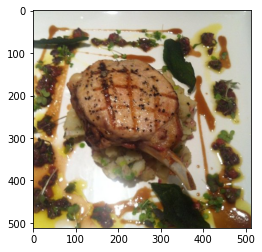

In [17]:
plt.imshow(food_use["test"][0]["image"])
print(id2label[str(food["test"][0]["label"])])

In [18]:
preds_output = trainer.predict(food["test"])

***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


In [19]:
preds_output.metrics

{'test_loss': 0.2781291604042053,
 'test_runtime': 12.7425,
 'test_samples_per_second': 78.478,
 'test_steps_per_second': 9.81}

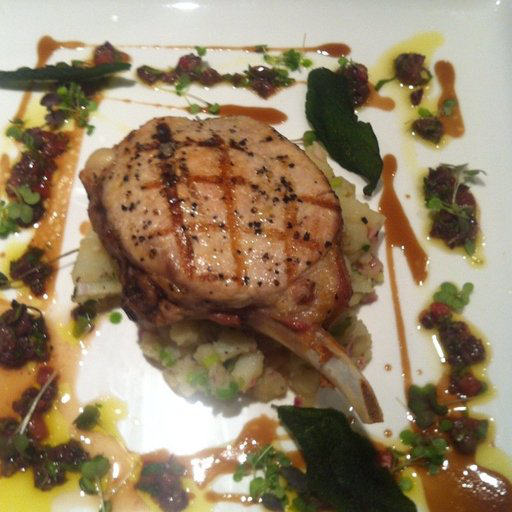

In [20]:
food_use["test"][0]["image"]

In [21]:
actual = food_use["test"][0]["label"]
predictions = preds_output.label_ids

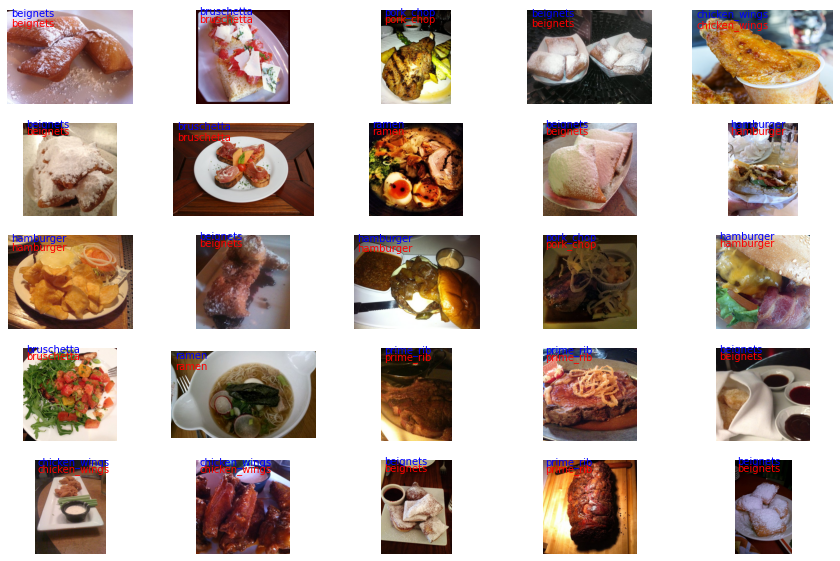

In [22]:
fig, axArr = plt.subplots(5,5,figsize=(15,10));
# loop through all rows
for currRow in range(5):
 # loop through all columns
 for currCol in range(5):
 # select the random digi
  n = np.random.randint(0,len(food_use["test"]))
  randomDigitImage = food_use["test"][n]["image"]
  randomDigitLabel = id2label[str(food_use["test"][n]["label"])]
  prediction = id2label[str(preds_output.label_ids[n])]
 
 # plot it
  currentAxis = axArr[currRow,currCol];
  currentAxis.axis('off');
 
  currentAxis.imshow(randomDigitImage);
  currentAxis.text(15,25,str(randomDigitLabel),color='blue',fontsize=10);
  currentAxis.text(15,65,str(prediction),color='red',fontsize=10);

In [23]:
import pandas as pd

In [24]:
actual = food_use["test"][:]["label"]
predictions = preds_output.label_ids
df_result = pd.DataFrame({"actual":actual,"predicted":predictions})
df_result

,actual,predicted
0,77,77
1,81,81
2,10,10
3,77,77
4,6,6
...,...,...
995,81,81
996,53,53
997,10,10
998,20,20


In [25]:
correct = len(df_result[df_result["actual"] == df_result["predicted"]])
incorrect = len(df_result[df_result["actual"] != df_result["predicted"]])

print("Proportion of Correct Predictions:%.2f"%((correct)/(correct+incorrect)))
print("Proportion of Inorrect Predictions:%.2f"%((incorrect)/(correct+incorrect)))

Proportion of Correct Predictions:1.00
Proportion of Inorrect Predictions:0.00
